In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def displace(Path,α,i,δ=0.25):
    '''Single bead displace update.
    
       NB: not implemented for periodic boundary conditions.
    '''
    # Calculate the action
    x = Path.beads[α,i]
    oldAction = Path.kinetic_action(α,i) + Path.potential_action(α)

    # Displace the bead
    Path.beads[α,i] += δ*(-1.0 + 2.0*np.random.random())

    # Compute the new action
    newAction = Path.kinetic_action(α,i) + Path.potential_action(α)
    
    # Accept the move, or reject and restore the bead position
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α,i] = x
        return False

In [52]:
def staging(Path,m,i):
    '''Multi-slice update which eactly samples the free particle 
       propagator between two fixed beads.

       See: http://link.aps.org/doi/10.1103/PhysRevB.31.4234
    
       NB: not implemented for periodic boundary conditions.
    '''
    # choose the start and end of the stage
    α_start = np.random.randint(low=0,high=Path.num_time_slices)
    α_end = α_start + m
    
    # if we move off the end of the path, reject the move
    if α_end >= Path.num_time_slices:
        return False

    # Record the positions of the beads to be updated and store the action
    x = np.copy(Path.beads[α_start+1:α_end,i])
    oldAction = 0.0
    for α in range(α_start+1,α_end):
        oldAction += Path.potential_action(α)

    # Generate new positions and accumulate the new action
    newAction = 0.0;
    for α in range(α_start+1,α_end):
        Δτ1 = Path.Δτ   
        Δτ2 = (α_end - α)*Path.Δτ
        avex = (Δτ2*Path.beads[α-1,i] + Δτ1*Path.beads[α_end,i])\
                / (Δτ1 + Δτ2)
        σ = np.sqrt(2.0*Path.λ / (1.0/Δτ1 + 1.0/Δτ2))
        Path.beads[α,i] = np.random.normal(loc=avex,scale=σ)
        newAction += Path.potential_action(α)

    # Perform the Metropolis step, if we reject, revert the worldline
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α_start+1:α_end,i] = x
        return False

In [34]:
def find_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



In [55]:
int(80/2.4)

33

In [56]:
def pigs(num_MC_steps,num_equil_steps,Path,m=28):
    '''Perform a path integral ground state Monte Carlo simulation.'''

    # set up m
    m = int(M/2.4)
    
    # grid for density
    num_grid = 60
    grid_x = np.linspace(-2, 2, num_grid)
    drho = 1/num_grid/(num_MC_steps-num_equil_steps)
    
    # initialize estimators and acceptance counters
    numAccept = {'displace':0,'staging':0}
    estimator = {'E':np.zeros(num_MC_steps-num_equil_steps),
                 'Vslice':np.zeros([num_MC_steps-num_equil_steps,Path.num_time_slices]), 
                 'density':np.zeros((Path.num_time_slices, num_grid)), 
                 'integrate':np.zeros(3)}
    


    measure = 0
    for step in range(num_MC_steps): 
        
        # for each particle and slice try a displace move
        for α in range(Path.num_time_slices):
            for i in range(Path.N):
                numAccept['displace'] += displace(Path,α,i)

        # for each particle try a number of staging moves
        num_stage = int(Path.num_time_slices/m)
        for stage in range(num_stage):
            for i in range(Path.N): 
                numAccept['staging'] += staging(Path,m,i)

        # measure the energy
        if step >= num_equil_steps:
            measure = step-num_equil_steps
            estimator['E'][measure],estimator['Vslice'][measure] = Path.Energy()
            
            # store bead for a sigle particle
            for α in range(Path.num_time_slices):
                idx = find_idx(grid_x,Path.beads[α,0])
                estimator['density'][α, idx] += drho
            
    # density lower half state
    lowerhalf = estimator['density'][:M-1, :]
    lowerhalf = lowerhalf.mean(axis=0)
    lhsqure = np.asarray([lf*lf for lf in lowerhalf])
    lhsum = lhsqure.sum()
    lhnorm = np.asarray([lf/np.sqrt(lhsum) for lf in lowerhalf])
    #upper half
    upperhalf = estimator['density'][M+1:, :]
    upperhalf = upperhalf.mean(axis=0) 
    uhsqure = np.asarray([uf*uf for uf in upperhalf])
    uhsum = uhsqure.sum()
    uhnorm = np.asarray([uf/np.sqrt(uhsum) for uf in upperhalf])
    
    #corr
    corr_lflf = lhnorm * lhnorm
    integral_lflf = corr_lflf.sum()
    corr_ufuf = uhnorm * uhnorm
    integral_ufuf = corr_ufuf.sum()
    corr_lfuf = lhnorm * uhnorm
    integral_lfuf = corr_lfuf.sum()
    estimator['integrate'][0] = integral_lflf
    estimator['integrate'][1] = integral_ufuf
    estimator['integrate'][2] = integral_lfuf
    
    print('displace: %4.3f' %
          ((1.0*numAccept['displace'])/(num_MC_steps*Path.num_time_slices*Path.N)))
    print('staging:  %4.3f' %
          ((1.0*numAccept['staging'])/(num_MC_steps*Path.N*num_stage)))
    print('lflf: %4.3f' % integral_lflf)
    print('ufuf: %4.3f' % integral_ufuf)
    print('lfuf: %4.3f' % integral_lfuf)
    
    return estimator

In [58]:
class Paths:
    '''The set of worldlines, action and estimators.'''
    def __init__(self,beads,M,Δτ,λ,V0,Δe,ω1,a,b):
        self.Δτ = Δτ
        self.λ = λ
        self.M = M
        self.beads = np.copy(beads)
        self.num_time_slices = len(beads)
        self.N = len(beads[0])
        self.V0 = V0
        self.Δe = Δe
        self.ω1 = ω1
        self.a = a
        self.b = b
        self.norm = np.ones(self.num_time_slices)
        
        self.norm[0] = self.norm[-1] = 0.5

        
    def V(self,α,x):
        '''non-symmetric left weighted well for lower half, right weighted well for upper half'''
        a = self.a
        b = self.b
        v = 0
    
        if (-b-a<x<-b+a):
            if α-self.M > 0.9:
                v = self.Δe*(1.0)
        elif (b-a<x<+b+a):
            if α-self.M < -0.9:
                v = self.Δe*(1.0)
        else:
            v = self.V0
    
#        '''non-symmetric left weighted well for lower half'''
#        if (-b-a<x<-b+a):
#            v = 0
#        elif (b-a<x<+b+a):
#            if α-self.M < -0.9:
#                v = self.Δe*(1.0)
#        else:
#            v = self.V0
        
#        '''non-symmetric right weighted well for upper half'''
#        if (-b-a<x<-b+a):
#            if α-self.M > 0.9:
#                v = self.Δe*(1.0)
#        elif (b-a<x<+b+a):
#            v = 0
#        else:
#            v = self.V0
        
        return v
    
    def Vint(self, xi, xj):
        '''harmonic interaction potential'''
        ω = self.ω1
        return ω*ω*(xi-xj)**2 /(4.0*self.λ)
    
    def Ψ(self, xi, xj):
        '''trial wave function'''
        psi = 5.0/5.0*(1.0/np.cosh(np.sqrt(np.pi/2)*(xi+b)/a)+1.0/np.cosh(np.sqrt(np.pi/2)*(xi-b)/a))
        return psi
    
    def kinetic_action(self,α,i):
        '''kinetic action of a bead.'''
        
        if α == 0.0:
            cK = (self.beads[α+1,i]-self.beads[α,i])**2
        elif α == 2*self.M:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2
        else:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2 + (self.beads[α+1,i]-self.beads[α,i])**2
        return cK / (4*self.λ*self.Δτ)

    def potential_action(self,α):
        '''potential action of a slice.'''
        cV = 0.0
        ΨT = 1.0
            
        for i in range(self.N):
            xi = self.beads[α,i]
            cV += self.norm[α]*self.V(α,xi)
            
            for j in range(self.N):
                xj = self.beads[α,j]
                if i<j:
                    cV += self.norm[α]*self.Vint(xi, xj)    
                # add the wavefunction at the ends of the path
                if α == 0 or α == 2*self.M:
                    ΨT *= self.Ψ(xi, xj)
                
        return self.Δτ*cV - np.log(ΨT)
    

    def Energy(self):
        '''The total energy.'''
                
        # the kinetic part
        norm = 1.0/(4.0*self.λ*self.Δτ**2)
        KE = 0
        for α in range(self.M-1, self.M+1):
            for i in range(self.N):
                ΔR = self.beads[α+1,i] - self.beads[α,i]
                KE +=  - norm*np.dot(ΔR,ΔR)
                
        KE /= 2
        KE += 0.5*self.N/self.Δτ
        
        # the potential part
        PE = 0.0
        Vslice = np.zeros(self.num_time_slices)
        for α in range(self.M-1, self.M+1):
            for i in range(self.N):
                cV = self.V(α,self.beads[α,i])
                for j in range(self.N):
                    if i<j:
                        cV += self.Vint(self.beads[α,i], self.beads[α,j])
                Vslice[α] += cV
                PE += self.norm[α]*cV
        
        PE /= 2
        
        return KE + PE, Vslice
    


    def Vleft_o(self,α,x):
        '''non-symmetric left weighted well for lower half'''
        a = self.a
        b = self.b
        v = 0
        if (-b-a<x<-b+a):
            v = 0
        elif (b-a<x<+b+a):
            if α-self.M < -0.9:
                v = self.Δe*(1.0)
        else:
            v = self.V0
        return v

    def Vright_o(self,α,x):
        '''non-symmetric right weighted well for upper half'''
        a = self.a
        b = self.b
        v = 0
        if (-b-a<x<-b+a):
            if α-self.M > 0.9:
                v = self.Δe*(1.0)
        elif (b-a<x<+b+a):
            v = 0
        else:
            v = self.V0
        return v
    
    def one(self):
        '''one'''     
        return 1, 1

displace: 0.450
staging:  0.287
Ē = 1.098744 ± 0.015895


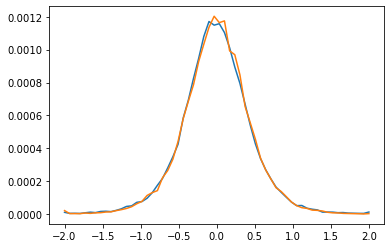

In [8]:
# setup the simulation for [single well]
M,N,τ,λ,V0,Δe,ω1,a,b = 60,1,6.0,0.5,2.0,0,0,0.5,0
Δτ = τ/M

# random initial positions
np.random.seed(1173)
beads = -0.5 + np.random.random([2*M+1,N])

# setup the paths
Path = Paths(beads,M,Δτ,λ,V0,Δe,ω1,a,b)

# compute the energy via path integral ground state Monte Carlo
num_MC_steps = 100000
num_equil_steps = 20000
estimator = pigs(num_MC_steps,num_equil_steps,Path)

from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
V̄slice,ΔV̄slice = np.average(estimator['Vslice'],axis=0),sem(estimator['Vslice'],axis=0)
one = 

# grid for density
num_grid = 60
grid_x = np.linspace(-2, 2, num_grid)
drho = 1/num_grid/(num_MC_steps-num_equil_steps)
plt.plot(grid_x ,estimator['density'][0,:])
plt.plot(grid_x ,estimator['density'][2*M,:])

print('Ē = %f ± %f' % (Ē,ΔĒ))
E_single = [float(Ē),float(ΔĒ)]

In [9]:
from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E'][20000:]),sem(estimator['E'][20000:])
print('Ē = %f ± %f' % (Ē,ΔĒ))

Ē = 1.080130 ± 0.018378


In [10]:
def cumulativeMovingAverage(data):
    '''Compute the cumulative mean as a function of bin index.'''
    CMA = np.zeros_like(data)
    CMA[0] = data[0]
    for n in range(len(data)-1):
        CMA[n+1] = (data[n+1] + n*CMA[n])/(1.0*(n+1))
    return CMA

cumave = cumulativeMovingAverage(estimator['E'])

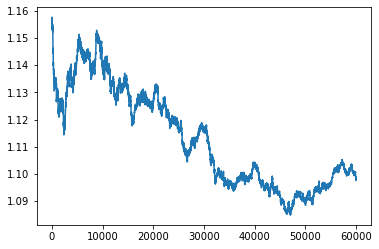

In [11]:
plt.plot(cumave[20000:])

In [16]:
τ_array = np.linspace(6,16,6)
M = [int(i*10.0) for i in τ_array]
m = [int(i/1.85) for i in M]
print(τ_array)
print(M)
print(m)

[ 6.  8. 10. 12. 14. 16.]
[60, 80, 100, 120, 140, 160]
[32, 43, 54, 64, 75, 86]


In [17]:
τ_array = np.linspace(6,16,6)

Ē_array_τ = np.zeros(6)
ΔĒ_array_τ = np.zeros(6)

for τi in range(len(τ_array)):
    # setup the simulation
    N,λ,V0,Δe,ω1,a,b = 1,0.5,2.0,0,0,0.5,0
    M = int(τ_array[τi]*10.0)
    τ = τ_array[τi]
    Δτ = τ/M

    # random initial positions
    np.random.seed(1173)
    beads = -0.5 + np.random.random([2*M+1,N])

    # setup the paths
    Path = Paths(beads,M,Δτ,λ,V0,Δe,ω1,a,b)

    # compute the energy via path integral ground state Monte Carlo
    num_MC_steps = 100000
    num_equil_steps = 20000
    estimator = pigs(num_MC_steps,num_equil_steps,Path)

    from scipy.stats import sem
    Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
    V̄slice,ΔV̄slice = np.average(estimator['Vslice'],axis=0),sem(estimator['Vslice'],axis=0)

    Ē_array_τ[τi] = Ē
    ΔĒ_array_τ[τi] = ΔĒ

displace: 0.450
staging:  0.287
displace: 0.449
staging:  0.206


KeyboardInterrupt: 

In [ ]:
plt.axhline(y=1.09249, color='green', linewidth=1.0, label='Exact')
plt.errorbar(τ_array, Ē_array_τ, yerr=ΔĒ_array_τ, marker='o', color='blue', 
             linewidth=1.0, elinewidth=1.0, markersize=6, markerfacecolor='blue', markeredgecolor='blue', 
             ecolor='blue', label='QMC')
plt.xlabel(r'$\tau$')
plt.ylabel('E')
plt.legend();

displace: 0.780
staging:  0.306
lflf: 1.000
ufuf: 1.000
lfuf: 0.137
Ē = 0.875189 ± 0.054838


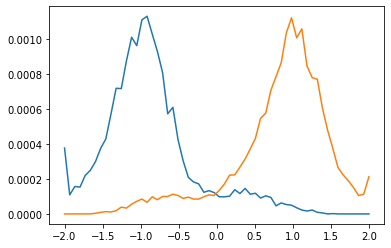

In [59]:
# setup the simulation for [double well]
M,N,τ,λ,V0,Δe,ω1,a,b = 80,1,8.0,0.5,2.0,2,0,0.5,1
Δτ = τ/M

# random initial positions
np.random.seed(1173)
beads = -0.5 + np.random.random([2*M+1,N])

# setup the paths
Path = Paths(beads,M,Δτ,λ,V0,Δe,ω1,a,b)

# compute the energy via path integral ground state Monte Carlo
num_MC_steps = 10000
num_equil_steps = 1000
estimator = pigs(num_MC_steps,num_equil_steps,Path)

from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
V̄slice,ΔV̄slice = np.average(estimator['Vslice'],axis=0),sem(estimator['Vslice'],axis=0)

# grid for density
num_grid = 60
grid_x = np.linspace(-2, 2, num_grid)
drho = 1/num_grid/(num_MC_steps-num_equil_steps)
plt.plot(grid_x ,estimator['density'][0,:])
plt.plot(grid_x ,estimator['density'][2*M,:])

print('Ē = %f ± %f' % (Ē,ΔĒ))
E_double = [float(Ē),float(ΔĒ)]

In [15]:
# Analytic form of 𝛿 is shown below
# Em is analytic solution of the equation below (Same with E_single_well)
def delta(Path):
    Em = 1.09249
    return 4*(V0-Em)*Em*np.exp(-2*(b-a)*np.sqrt((V0-Em)/λ))/V0/(a*np.sqrt((V0-Em)/λ) +1)

approx = delta(Path)
print(approx)

0.3079999077341899


\begin{equation}
\sqrt{V-E_{m}}=\sqrt{E_{m}}\tan\left(\sqrt{E_{m}/\lambda}a\right)
\end{equation}
\begin{equation}
\delta=4\frac{\left(V-E_{m}\right)E_{m}e^{-2\left(b-a\right)\sqrt{\left(V-E_{m}\right)/\lambda}}}{V\left(a\sqrt{\left(V-E_{m}\right)/\lambda}+1\right)}
\end{equation}

In [18]:
print("PIGS result: ",E_single[0]-E_double[0])
print("Analytic result: ", approx)

PIGS result:  0.1491379053264701
Analytic result:  0.3079999077341899


from sympy import symbols, solve, sqrt, tan
import math

def sol(Path):
    x = symbols('x')
    #a1 = np.sqrt(V0-Em)
    #a2 = np.sqrt(Em)*math.tan(np.sqrt(Em/λ)*a)
    expr = sqrt(V0-x) - sqrt(x)*tan(sqrt(x/λ)*a)
    sol = solve(expr)
    return sol

solution = sol(Path)
print(solution)

def hist()
    for step in range(num_MC_steps): 
        
        # for each slice save location
        for α in range(Path.num_time_slices):
            


        # measure the energy
        if step >= num_equil_steps:
            measure = step-num_equil_steps
            estimator['E'][measure],estimator['Vslice'][measure] = Path.Energy()